<h1><center>Opmatch</center>
</h1>

<center>A lightweight package for optimal case-control matching.</center>

<h3 align="center">
    <a href="#-getting_started">Getting Started</a>&bull;
    <a href="#-Introduction">Introduction</a> &bull;
    <a href="#-quick-tour">Quick Tour</a>
</h3>

## ⚡️ Getting Started
-------------------------

```bash
pip install opmatch
```
or
```bash
conda install -c conda-forge opmatch
```

## 📚 Introduction 
-------------------------------

#### Optimal Matching
With this package, we provide a tool to perform optimal case-control/treated-untreated matching for observational studies. 
In optimal matching, the sum of all the pairwise case-control distances is minimized.
We can perform matching with constant and variable matching ratio using the assignment algorithm by constructing an appropriate distance matrix. If interested in details, please see Ming and Rosenbaum<sup>1</sup>. 

#### Why variable ratio matching? 
Optimal matching in its simplest form assigns one control to every case. However, if we have a large pool of controls it might be beneficial to have multiple cases matched to each control. This involves a bias-variance tradeoff. Higher matching ratio is associated with higher bias and a lower variance. We can also increase the power of an observational study by increasing the matching ratio. However, some cases might not have close controls, so increasing the overall matching ratio will result in bad matches for some cases. A more sophisticated procedure is matching with a variable ratio. Cases which have more controls closeby will have more matched controls<sup>2</sup>. Thus, a variable ratio match results in more closely matched sets and has the only downside of a slightly more involved statistical analysis of covariate balance<sup>3</sup>

#### Full Matching
A method superior to matching with a constant or variable ratio is full matching<sup>4</sup>. Full matching, in addition to having multiple controls per case, also allows to have multiple cases per control and thus includes other method as a special case. 

<sub><sup>[1] Ming, Kewei, and Paul R. Rosenbaum. "A note on optimal matching with variable controls using the assignment algorithm." Journal of Computational and Graphical Statistics 10.3 (2001): 455-463.</sub></sup><br>
<sub><sup>[2] Stuart, Elizabeth A. "Matching methods for causal inference: A review and a look forward." Statistical science: a review journal of the Institute of Mathematical Statistics 25.1 (2010): 1.</sub></sup><br>
<sub><sup>[3] Rosenbaum, Paul R., P. R. Rosenbaum, and Briskman. Design of observational studies. Vol. 10. New York: Springer, 2010.</sub></sup><br>
<sub><sup>[4] Cochran, William G., and S. Paul Chambers. "The planning of observational studies of human populations." Journal of the Royal Statistical Society. Series A (General) 128.2 (1965): 234-266.</sub></sup>

## 🚀 Quick Tour
----------------------------------

To obtain matches you can simply run:

```python
from opmatch.matcher import Matcher
case_control_dict = Matcher(
        df, matching_ratio, 
        min_mr, max_mr, n_controls, 
        metric, matching_type,
        case_col, var_cols,  ps_col,
        ).match()
```
>#### Parameters

* **matching_ratio** number of controls per case if matching ratio is constant

* **min_mr**: minimum number of controls per case
* **max_mr**: maximum number of controls per case
* **n_controls**: number of controls to match
* **metric**: PS or one of the metrics accepted by scipy.spatial.distances.cdist
* **matching_type**: constant or variable matching ratio
* **case_col**: boolean column where cases are 1s and controls 0s
* **var_cols**: columns containing relevatn patient variables
        if metric!=PS: var_cols used for matching
        if metric==PS but ps_col is not specified: var_cols used to compute PS using logistic regression
* **ps_col**: column containing the propensity score
* **case_col**: column name of case column, should contain 1s and 0s





### Generate Example Data

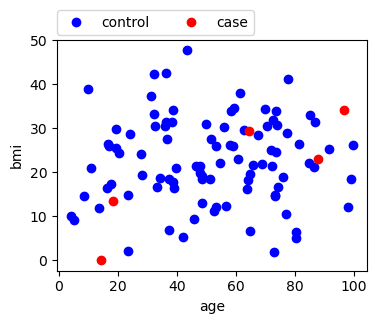

In [1]:
from opmatch.tutorial import example_data, vis

df = example_data.generate(100, 5)
vis.age_bmi_scatter_2d(df)

### Perform matching

In [2]:
from opmatch.matcher import Matcher
cc_dic_const = Matcher(df=df, matching_ratio=5, metric='mahalanobis', 
            matching_type='const', var_cols=['age','bmi']).match()
cc_dic_ps = Matcher(df=df, min_mr=1, max_mr=5, n_controls=15, metric='PS', 
            matching_type='variable', var_cols=['age','bmi']).match()
cc_dic_variable = Matcher(df=df, min_mr=1, max_mr=5, n_controls=15, metric='mahalanobis', 
            matching_type='variable', var_cols=['age','bmi']).match()

Number of cases: 5
Size of the control pool: 95
Number of cases: 5
Size of the control pool: 95
Number of cases: 5
Size of the control pool: 95


c:\Users\fjn197\PhD\projects\opmatch\opmatch\matcher.py:78: UserWarning: Propensity score column name not passed, and 'ps'/'PS' not found in df, perform logistic regression on var_cols, to compute ps
  warnings.warn("Propensity score column name not passed, and 'ps'/'PS' not found in df, perform logistic regression on var_cols, to compute ps")


### Visualize

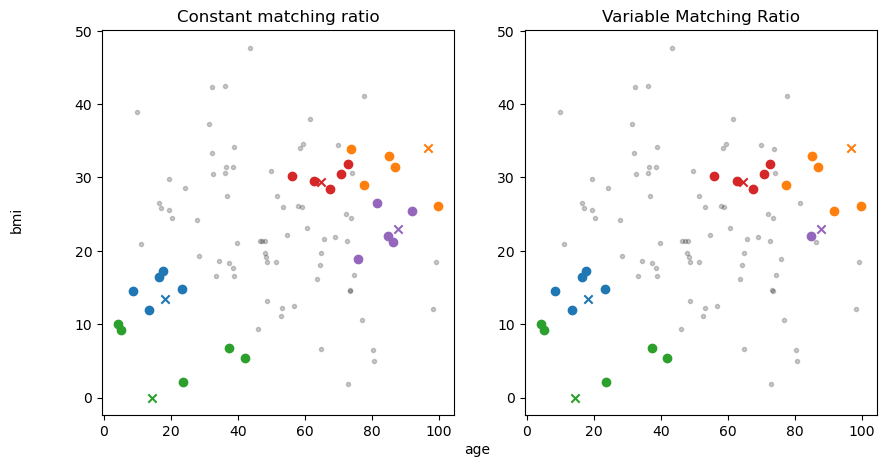

In [3]:
vis.visualize_matched_scatter(df, [cc_dic_const, cc_dic_variable], titles=['Constant matching ratio', 'Variable Matching Ratio'])

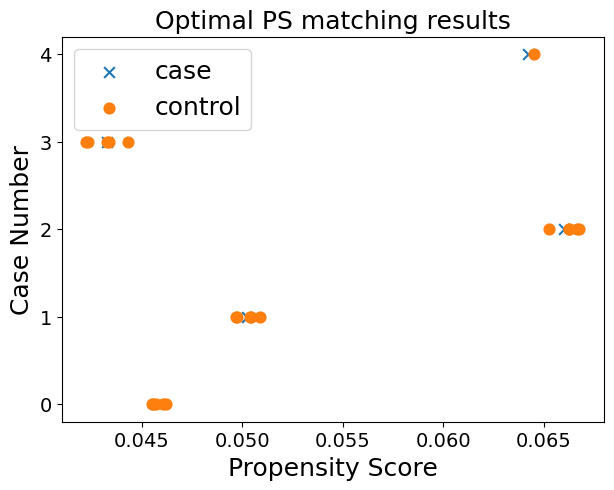

In [4]:
vis.plot_ps_matched(df.ps, case_control_dic=cc_dic_ps)